# Разработка модели

https://github.com/154King154/bot_classify - репозиторий проекта

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

from fastai.vision import *

plt.ion()

# В этой части нужно загрузить датасет, разделить его на тренировочную и валидационную выборки и разложить картинки по папкам, чтобы в одной папке лежали картинки одного класса.



Используемый мной датасет https://www.kaggle.com/jessicali9530/stanford-dogs-dataset/
Его я использовал полностью как train, a для validation собирал картинки в гугле, примерно еще 8500 картинок.
Обучение происходило в колабе, т.к. компьютер чуточку не потянул.

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
#/content/drive/Team Drives/mlearn
#path to files 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from pathlib import Path
#PATH = Path('/home/alex/dogs_dataset/')
PATH = Path('/content/drive/My Drive/dlschool_project/data_dogs')
print(PATH)
tfms = get_transforms(do_flip=True,
                     flip_vert=False,
                     max_rotate=10.0,
                     max_zoom=0.5,
                     max_lighting=0.9,
                     max_warp=0.2)
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, bs=16, size=256)

/content/drive/My Drive/dlschool_project/data_dogs


# Теперь перейдем к созданию модели

In [0]:
# если мы создаем предобученную модель, то все слои, кроме последних полносвязных будут заморожены,
# стоит помнить об этом при обучении
model = create_cnn(data, models.vgg16_bn, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:22<00:00, 24221249.85it/s]


Я изучил решения классификации собак по этому датасету на кагле (Kernels) и увидел, что самым эффективным вариантом из всех является vgg16. Accur в данном случае может достигать 80% .



# Осталось обучить модель и проверить ее точность.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


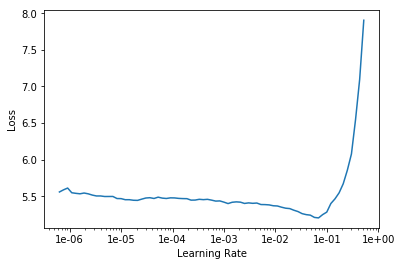

In [0]:
# Здесь мы используем lr_finder, чтобы выбрать скорость обучения
model.lr_find()
model.recorder.plot()

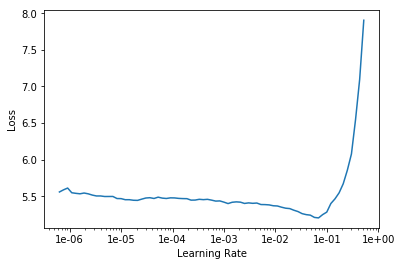

In [0]:
model.recorder.plot()

Как мы видим, эффективно использовать learning rate в пределах 1е-05 до 1е-02.

In [0]:
# используем 1cycle policy подрбнее https://docs.fast.ai/callbacks.one_cycle.html
model.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,4.915517,5.649846,0.013783,1:14:25


In [0]:
# теперь мы хотим разморозить всю модель и продолжить finetuning 
# слои объединены в группы, для каждой группы слоев можно поставить свой learning rate
# чтобы узнать, сколько есть групп, выведем их
model.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): ReLU(inplace)
   (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (12): ReLU(inplace)
   (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [0]:
model.unfreeze()
# установим learning rate для каждой из трех групп, делать их отличающимися на порядок
# хорошая идея в большинстве случаев, при этом lr для последнего слоя мы нашли из lr_find
model.fit_one_cycle(1, [1e-4, 1e-3, 1e-2])
model.export()

epoch,train_loss,valid_loss,accuracy,time
0,2.319810,1.910291,0.484066,1:04:54


In [0]:
model.fit_one_cycle(1, [1e-4, 1e-3, 1e-2])
model.fit_one_cycle(1, [1e-4, 1e-3, 1e-2])

epoch,train_loss,valid_loss,accuracy,time
0,1.800419,1.624959,0.557999,14:58


 # Сохраним веса

In [0]:
model.export()